<a href="https://colab.research.google.com/github/crissy09/Machine_Learning_Crissy_Rani/blob/main/Machine_Learning(Crisy_Rani).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [ ]:
# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
CSV_PATH = '/content/drive/MyDrive/codon_usage.csv'
df = pd.read_csv(CSV_PATH)
print("Dataset shape:", df.shape)
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (13028, 69)


/tmp/ipython-input-3797867564.py:7: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [ ]:
# Define meta and codon columns
meta_cols = ['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']
codon_cols = [c for c in df.columns if c not in meta_cols]
print("Meta columns:", meta_cols)
print("Number of codon feature columns:", len(codon_cols))

Meta columns: ['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName']
Number of codon feature columns: 64


# Preprocessing

**Check for missing values**

In [ ]:
print("MISSING VALUES")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0])


MISSING VALUES
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


**Outlier Handling**

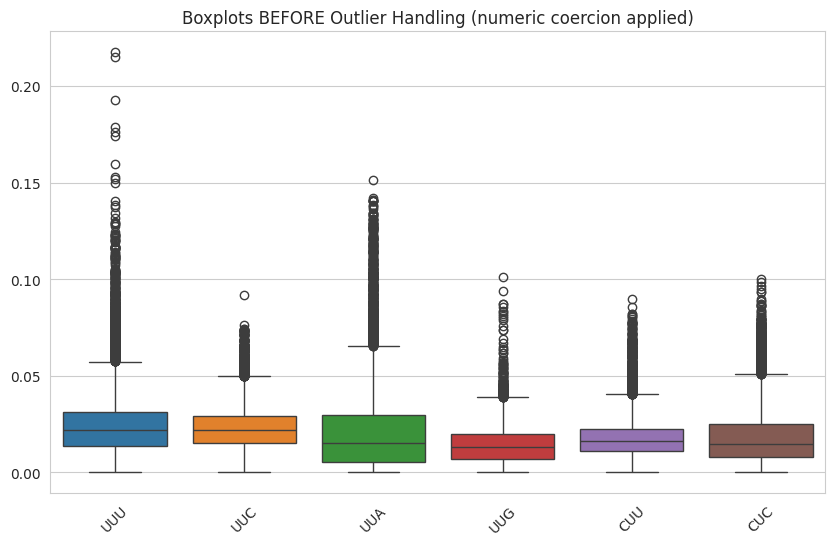

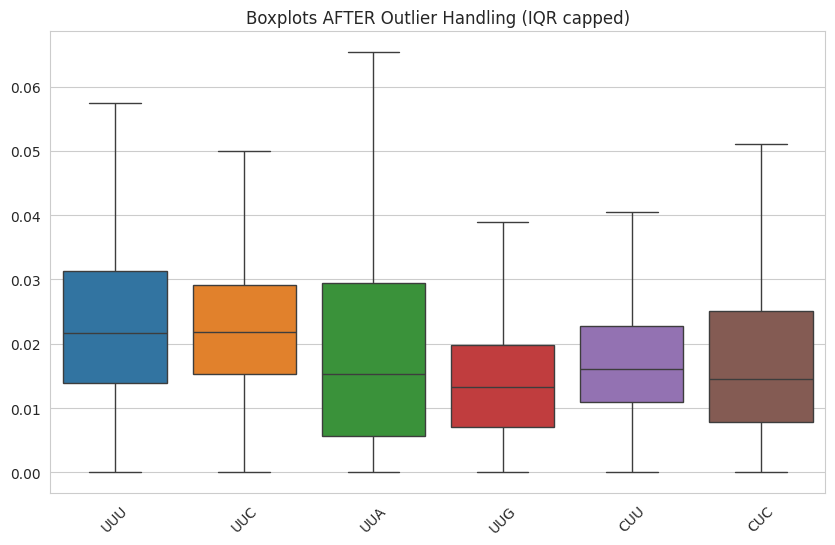

In [ ]:
# BOXPLOTS BEFORE outlier handling
df_num = df[codon_cols].apply(pd.to_numeric, errors='coerce')
sample_cols = codon_cols[:6]
plt.figure()
sns.boxplot(data=df_num[sample_cols])
plt.title("Boxplots BEFORE Outlier Handling (numeric coercion applied)")
plt.xticks(rotation=45)
plt.show()

# IQR capping function and application (winsorize)

def cap_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

df_capped = df_num.copy()
for col in codon_cols:
    if df_capped[col].notna().sum() == 0:
        continue
    df_capped[col] = cap_iqr(df_capped[col])

# BOXPLOTS AFTER outlier handling
plt.figure()
sns.boxplot(data=df_capped[sample_cols])
plt.title("Boxplots AFTER Outlier Handling (IQR capped)")
plt.xticks(rotation=45)
plt.show()

**Mean Imputation**

In [ ]:
# Impute any remaining NaNs in codon features (mean imputation)
imputer = SimpleImputer(strategy='mean')
df_capped[codon_cols] = imputer.fit_transform(df_capped[codon_cols])
print("Mean imputation done for codon features.")
print("Remaining NaNs in codon features:", df_capped[codon_cols].isna().sum().sum())

Mean imputation done for codon features.
Remaining NaNs in codon features: 0


**Label Encoding for Target Variable**

In [ ]:
target_col = 'Kingdom'
df_capped[target_col] = df[target_col]

le = LabelEncoder()
df_capped['y'] = le.fit_transform(df_capped[target_col].astype(str))

print("Target classes:", list(le.classes_))
print("Encoded mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Target classes: ['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod', 'vrl', 'vrt']
Encoded mapping: {'arc': np.int64(0), 'bct': np.int64(1), 'inv': np.int64(2), 'mam': np.int64(3), 'phg': np.int64(4), 'plm': np.int64(5), 'pln': np.int64(6), 'pri': np.int64(7), 'rod': np.int64(8), 'vrl': np.int64(9), 'vrt': np.int64(10)}


**Feature Scaling**

In [ ]:
X = df_capped[codon_cols].astype(float)
y = df_capped['y']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaling completed. Sample scaled values (first row, first 10 features):")
print(X_scaled[0][:10])

Scaling completed. Sample scaled values (first row, first 10 features):
[-0.51559585 -1.02436158 -1.11022891 -1.19184441 -0.58528124  1.0736303
 -1.0957604   1.56614899 -1.40360789 -0.34045843]


**Splitting data into training and testing**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (10422, 64) (2606, 64)


/tmp/ipython-input-1098975795.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Kingdom'], palette="viridis")


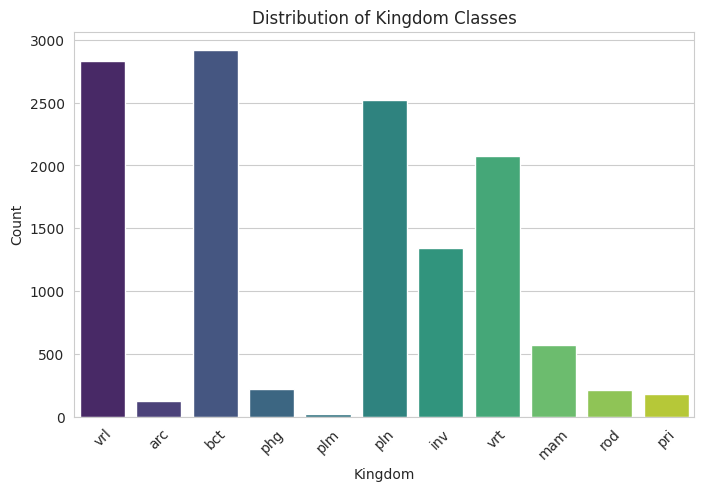

In [ ]:
# Distribution of Kingdom Classes
plt.figure(figsize=(8,5))
sns.countplot(x=df['Kingdom'], palette="viridis")
plt.title("Distribution of Kingdom Classes")
plt.xlabel("Kingdom")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


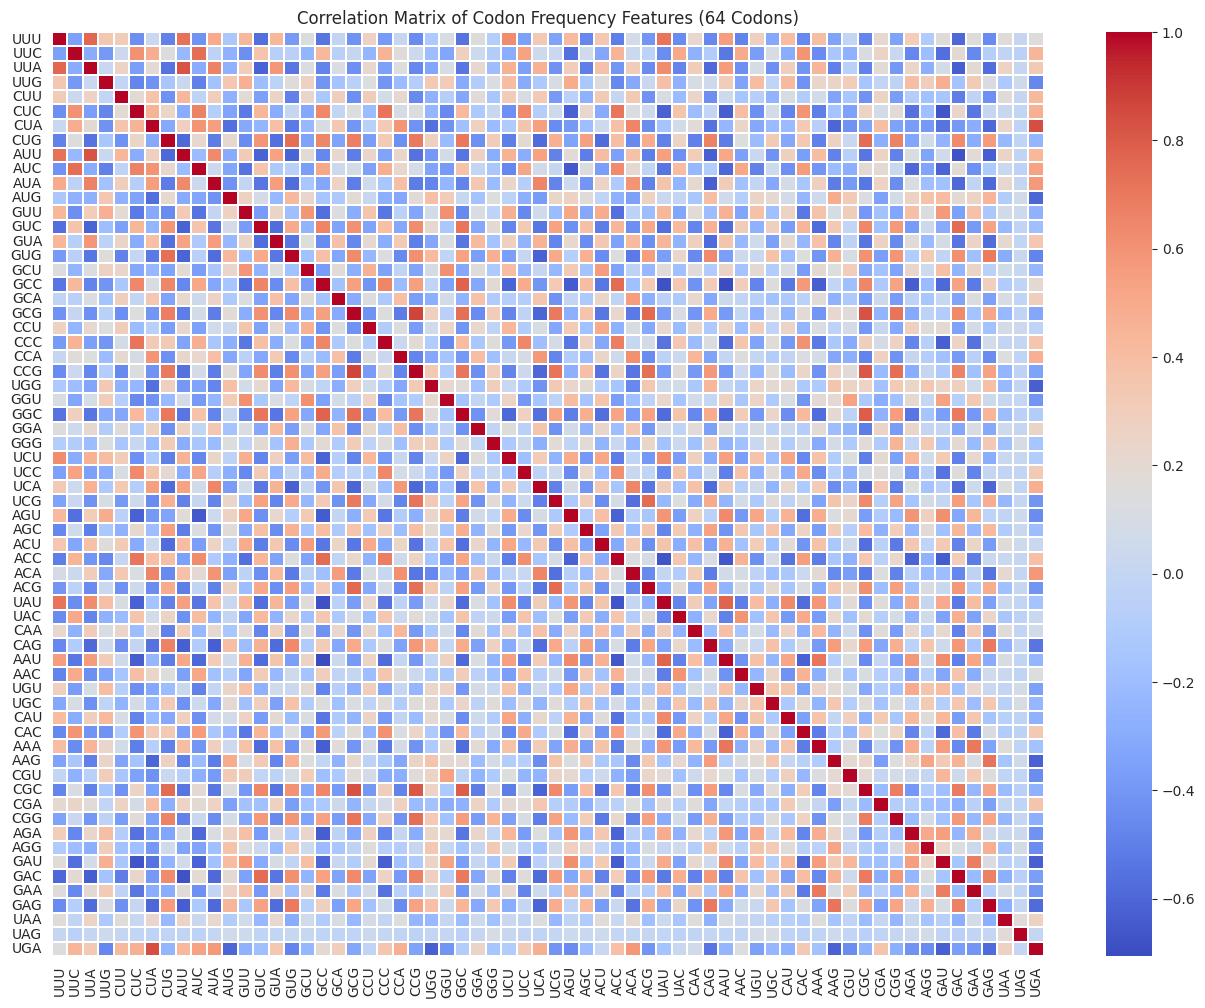

In [ ]:
# Correlation Matrix
codon_numeric = df[codon_cols].apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(16,12))
corr = codon_numeric.corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.2)
plt.title("Correlation Matrix of Codon Frequency Features (64 Codons)")
plt.show()


# CLASSIFICATION MODELS

**LOGISTIC REGRESSION**

Logistic Regression Accuracy: 0.8660782808902533
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        25
           1       0.92      0.94      0.93       584
           2       0.76      0.62      0.68       269
           3       0.81      0.76      0.79       114
           4       0.92      0.75      0.82        44
           5       0.00      0.00      0.00         4
           6       0.83      0.87      0.85       505
           7       0.66      0.58      0.62        36
           8       0.71      0.67      0.69        43
           9       0.89      0.92      0.90       567
          10       0.91      0.93      0.92       415

    accuracy                           0.87      2606
   macro avg       0.74      0.71      0.72      2606
weighted avg       0.86      0.87      0.86      2606



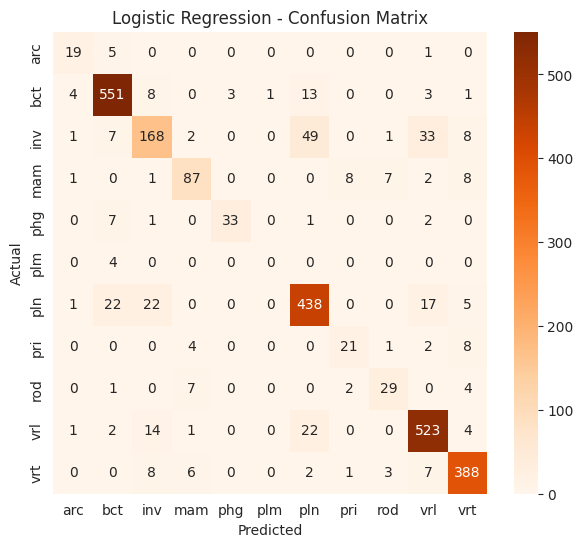

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


**LINEAR DISCRIMINANT ANALYSIS**

Linear Discriminant Analysis Accuracy: 0.8193
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        25
           1       0.90      0.91      0.91       584
           2       0.63      0.54      0.58       269
           3       0.80      0.70      0.75       114
           4       0.76      0.73      0.74        44
           5       0.00      0.00      0.00         4
           6       0.78      0.85      0.81       505
           7       0.41      0.58      0.48        36
           8       0.62      0.58      0.60        43
           9       0.86      0.90      0.88       567
          10       0.92      0.83      0.87       415

    accuracy                           0.82      2606
   macro avg       0.65      0.66      0.65      2606
weighted avg       0.82      0.82      0.82      2606



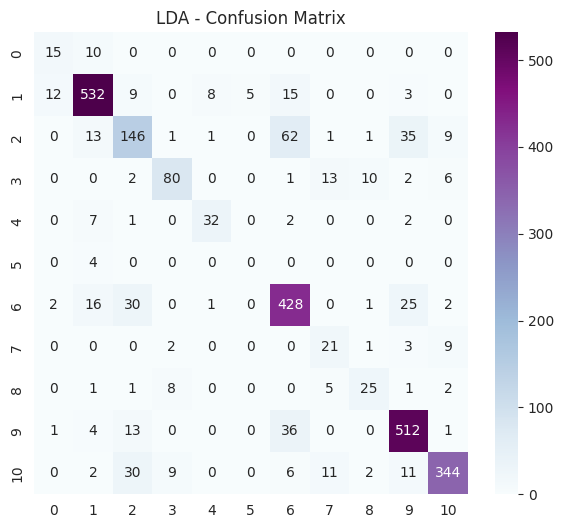

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

print("Linear Discriminant Analysis Accuracy:", round(accuracy_score(y_test, y_pred_lda),4))
print(classification_report(y_test, y_pred_lda))
cm = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(7,6)); sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu'); plt.title("LDA - Confusion Matrix"); plt.show()


**DECISION TREE**

Decision Tree Accuracy: 0.7629
              precision    recall  f1-score   support

           0       0.30      0.24      0.27        25
           1       0.82      0.84      0.83       584
           2       0.59      0.59      0.59       269
           3       0.70      0.69      0.70       114
           4       0.43      0.52      0.47        44
           5       0.25      0.25      0.25         4
           6       0.79      0.76      0.77       505
           7       0.50      0.58      0.54        36
           8       0.53      0.47      0.49        43
           9       0.80      0.80      0.80       567
          10       0.84      0.85      0.85       415

    accuracy                           0.76      2606
   macro avg       0.60      0.60      0.60      2606
weighted avg       0.76      0.76      0.76      2606



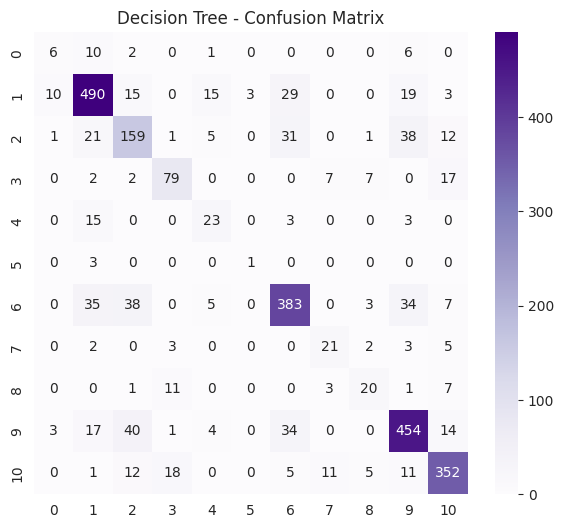

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", round(accuracy_score(y_test, y_pred_dt),4))
print(classification_report(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(7,6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Purples'); plt.title("Decision Tree - Confusion Matrix"); plt.show()


**HYPERPARAMETER TUNING: LOGISTIC REGRESSION (GridSearchCV)**

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Logistic Regression params: {'C': 1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.85

TUNED LOGISTIC REGRESSION - Test Accuracy: 0.8661

Classification Report:
               precision    recall  f1-score   support

         arc       0.70      0.76      0.73        25
         bct       0.92      0.94      0.93       584
         inv       0.76      0.62      0.68       269
         mam       0.81      0.76      0.79       114
         phg       0.92      0.75      0.82        44
         plm       0.00      0.00      0.00         4
         pln       0.83      0.87      0.85       505
         pri       0.66      0.58      0.62        36
         rod       0.71      0.67      0.69        43
         vrl       0.89      0.92      0.90       567
         vrt       0.91      0.93      0.92       415

    accuracy                           0.87      2606
   macro avg       0.74      0.71      0.72   

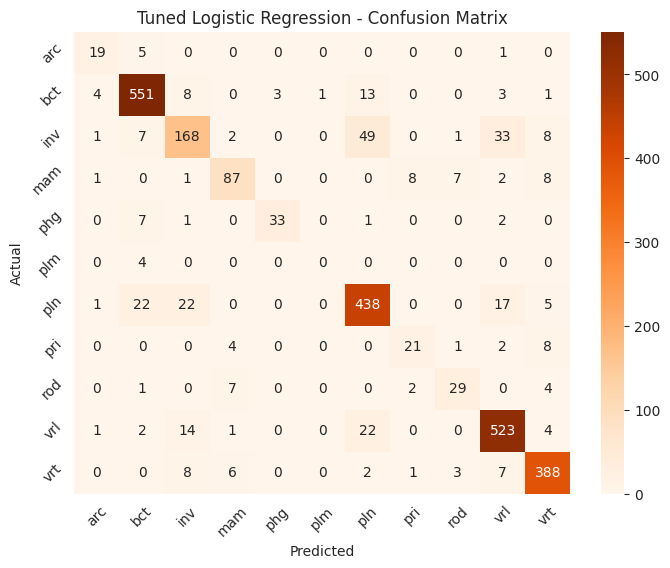

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [300]
}

logreg = LogisticRegression(
    random_state=42,
    multi_class='multinomial',
    warm_start=True
)

gs = GridSearchCV(
    logreg, param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

best_lr = gs.best_estimator_
print("Best Logistic Regression params:", gs.best_params_)
print("Best CV score:", round(gs.best_score_, 4))

y_pred_best = best_lr.predict(X_test)
print("\nTUNED LOGISTIC REGRESSION - Test Accuracy:", round(accuracy_score(y_test, y_pred_best), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, target_names=le.classes_))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Tuned Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks(rotation=45); plt.yticks(rotation=45)
plt.show()